In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio, phys_grad, compute_core_mean, axis_ratio

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies['TiltDis_diff'] = df_eddies.groupby('Eddy').TiltDis.diff()
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,Rc,psi0,A,R,Age,Date,fname,TiltDis,TiltDir,TiltDis_diff
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110,NaN
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602,1.930778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,11.563679,343.688930,1.507853
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803,1.284446
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')



In [3]:
with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)


In [4]:
def region_plotter(vmin=0, vmax=60, val='TiltDis', df_data=df_eddies):
    def _nice_step(h, base):
        s = h / base
        for k in [1, 2, 2.5, 5, 10]:
            if s <= k: 
                return k * base
        return np.ceil(s) * base
    
    def _grid_step(G):
        gx = np.diff(np.sort(np.unique(G.ravel())))
        return np.nanmedian(gx[gx > 0])
    
    def _bin_edges_fd(x, grid, scale=1.0, rule='fd'):
        x = np.asarray(x)
        x = x[np.isfinite(x)]
        n = len(x)
        if n < 2:
            lo, hi = np.nanmin(x), np.nanmax(x)
            return np.array([lo, hi])
    
        iqr = np.subtract(*np.percentile(x, [75, 25]))
        std = np.std(x, ddof=1)
    
        if rule.lower() == 'fd':
            bw = 2 * (iqr if iqr > 0 else 1.349 * std) / (n ** (1/3))
        else:
            bw = 3.5 * std / (n ** (1/3))
    
        if not np.isfinite(bw) or bw <= 0:
            rng = np.ptp(x)
            bw = rng / max(10, np.sqrt(n))
    
        base = _grid_step(grid)
        bw = _nice_step(scale * bw, base)
    
        lo = np.floor(np.nanmin(x) / bw) * bw
        hi = np.ceil(np.nanmax(x) / bw) * bw
        return np.arange(lo, hi + bw, bw)
    
    xbins = _bin_edges_fd(df_data.xc.values, X_grid, scale=1.0, rule='fd')
    ybins = _bin_edges_fd(df_data.yc.values, Y_grid, scale=1.0, rule='fd')
    
    levels_lat = [-40, -35, -30, -25]
    levels_lon = [150, 155, 160]
    
    from matplotlib.colors import Normalize
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmaps = {"AE-Day": "Reds", "CE-Day": "Blues"}
    
    def binned_median(x, y, v, xbins, ybins):
        ix = np.digitize(x, xbins) - 1
        iy = np.digitize(y, ybins) - 1
        nx, ny = len(xbins) - 1, len(ybins) - 1
        ok = (ix >= 0) & (ix < nx) & (iy >= 0) & (iy < ny) & np.isfinite(v)
    
        ix, iy, v = ix[ok], iy[ok], v[ok]
        flat = iy * nx + ix
    
        hmed = np.full(nx * ny, np.nan)
        for k in np.unique(flat):
            hmed[k] = np.nanmedian(v[flat == k])
    
        return hmed.reshape(ny, nx)
    
    fig, axs = plt.subplots(1, 2, figsize=(9, 8), sharey=True)
    
    for ax, cyc in zip(axs, ['AE-Day', 'CE-Day']):
        df = df_data[df_data.Cyc == cyc[:2]].copy()
        df = df.sort_values(val, kind='mergesort', ignore_index=True)
    
        ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')
    
        H = binned_median(df.xc.values, df.yc.values, df[val].values, xbins, ybins)
        m = ax.pcolormesh(xbins, ybins, H, cmap=cmaps[cyc], norm=norm,
                          shading='auto', rasterized=True)
        cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
        cb.set_label(f'{cyc} Median {val} [km]', fontsize=12)
        cb.set_ticks(np.linspace(vmin, vmax, 6))
    
        ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                    levels=[0.5, 1.5], colors=['k'], alpha=.5)
    
        c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                        colors='k', linewidths=.5)
        ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
        c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                        colors='k', linewidths=.5)
        ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    
        ax.axis('equal')
        ax.set_xlim(X_grid.min(), X_grid.max())
        ax.set_ylim(Y_grid.min(), Y_grid.max())
    
    for ax in axs:
        ax.set_xlabel('x (km)')
    axs[0].set_ylabel('y (km)')
    
    plt.tight_layout()
    plt.show()
    


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


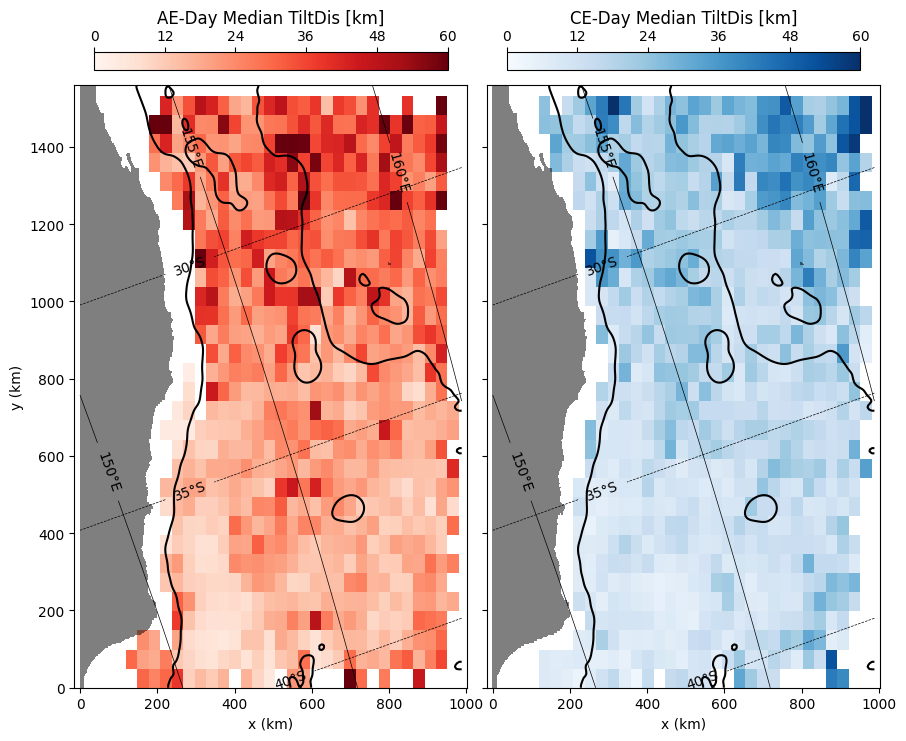

In [5]:
region_plotter()


In [6]:
df_eddies['w_abs'] = df_eddies.w.abs()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


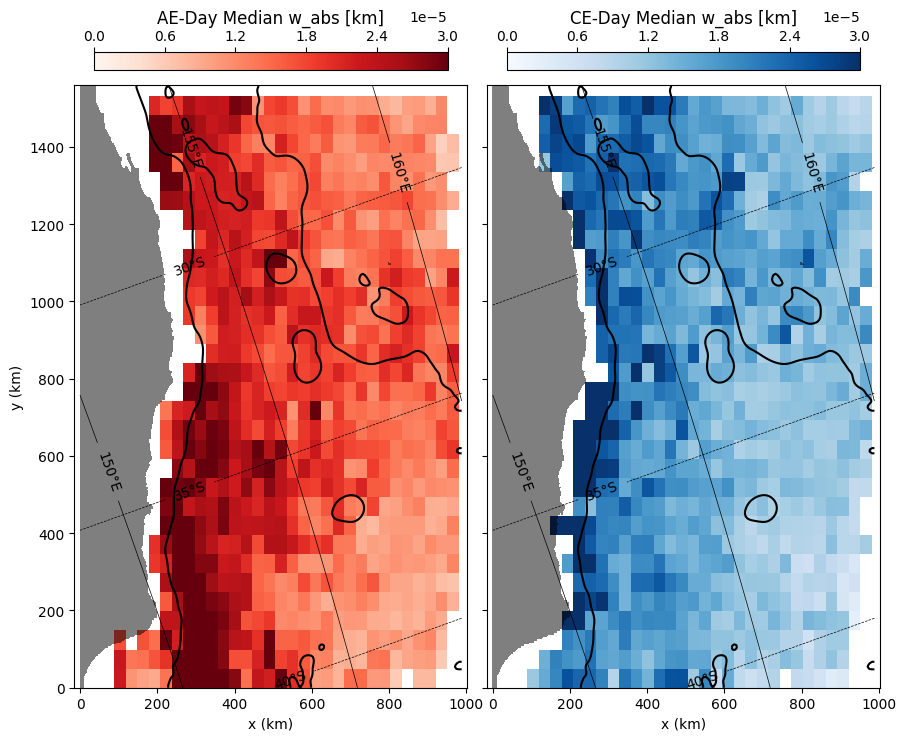

In [7]:
region_plotter(vmin=0, vmax=3e-5, val='w_abs', df_data=df_eddies)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


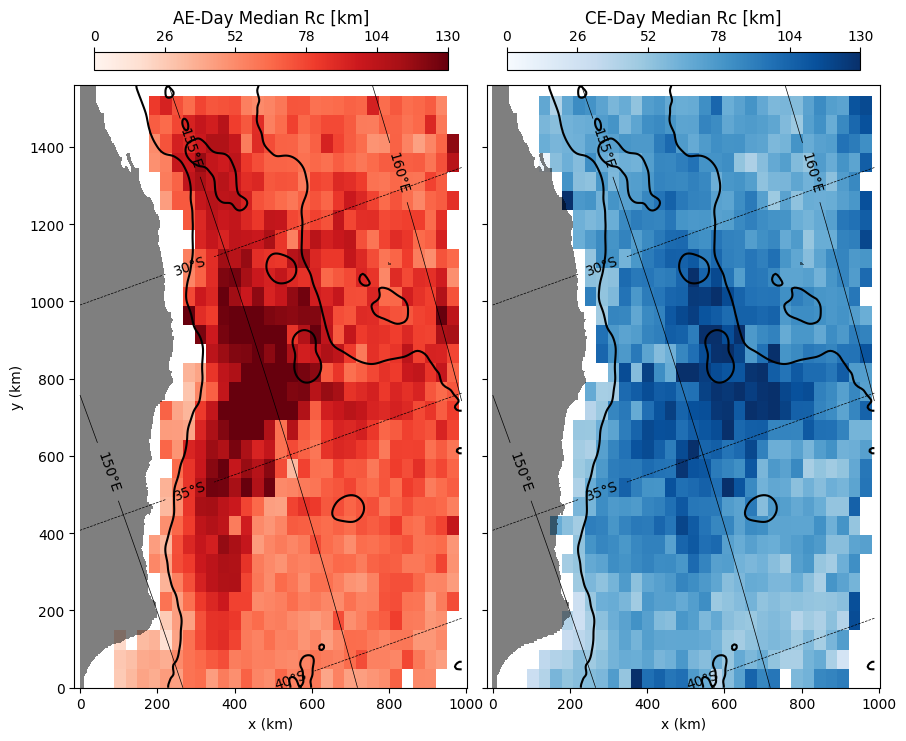

In [8]:
region_plotter(vmin=0, vmax=130, val='Rc', df_data=df_eddies)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


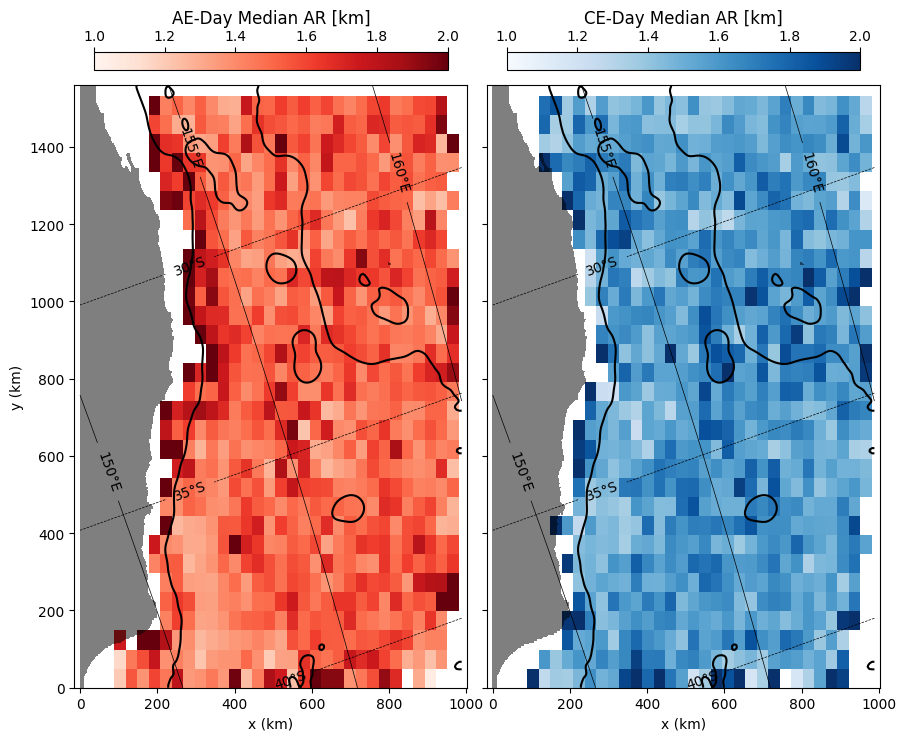

In [14]:
df_eddies['AR'] = axis_ratio(df_eddies)
region_plotter(vmin=1, vmax=2, val='AR', df_data=df_eddies)
